In [6]:
import uproot
import awkward
import numpy as np
import time
import pandas as pd
#from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from matplotlib import pyplot
#from sklearn.metrics import roc_curve, auc, roc_auc_score
#import keras
#from keras.models import Sequential
#from keras.layers import Dense
#from keras.layers import Flatten
#from sklearn.metrics import auc
#import seaborn as sns
import torch
from torch.utils.data.dataloader import DataLoader
#from sklearn.metrics import mean_squared_error
#from sklearn.metrics import accuracy_score
import torch.nn as nn
import torch.nn.functional as F
import timeit
import os

In [7]:
os.environ['CUDA_VISIBLE_DEVICES']="1"


In [8]:
#torch.cuda.is_available()

torch.cuda.empty_cache()

In [31]:
workpath = os.getcwd()
file_train = uproot.open(workpath+'/'+'data/train_D02kpipi0vxVc-cont0p5.root')
#file_test = uproot.open(workpath+'/'+'data/test_D02kpipi0vxVc-cont0p5.root')
tree_train = file_train['d0tree']
#tree_test = file_test['d0tree']
df_train = tree_train.arrays(library="pd")
#df_test = tree_test.arrays(library="pd")

In [10]:
df_train=df_train.drop(['vM','vpCMS','__index__'],axis=1)
#df_test=df_test.drop(['vM','vpCMS','__index__'],axis=1)

In [11]:
X_train = df_train.drop(['isSignal'],axis=1)
y_train = df_train['isSignal']
#X_test  =df_test.drop(['isSignal'],axis=1)
#y_test=df_test['isSignal']

In [12]:
test_x = torch.tensor(X_train.values.astype(np.float32))
test_y = torch.tensor(y_train.values.astype(np.int64))

In [13]:
test = df_train[df_train['isSignal']==0]
test_x = test.drop(['isSignal'],axis=1)
test_y = test['isSignal']
test_x = torch.tensor(test_x.values.astype(np.float32))
test_y = torch.tensor(test_y.values.astype(np.int64))

In [32]:
test_x.shape

torch.Size([20147, 12])

In [33]:
#sc=StandardScaler()
#X_train=sc.fit_transform(X_train)
#X_test=sc.transform(X_test)
#torch.cuda.current_device()

In [34]:
def device_available():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def feed_device(data,device):
    if isinstance(data, (list,tuple)):
        return [feed_device(x, device) for x in data]
    return data.to(device,non_blocking = True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield feed_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [35]:
class load():
    def load_train_tensor(self,X_train,y_train):
        X_train=torch.tensor(X_train.values.astype(np.float32))     
        y_train=torch.tensor(y_train.values.astype(np.int64))
        train_tensor = torch.utils.data.TensorDataset(X_train,y_train)
        train_loader = DataLoader(train_tensor, 32,shuffle =True )
        return train_loader
    def load_test_tensor(self):
        X_test=torch.tensor(X_test.values.astype(np.float32))
        y_test=torch.tensor(y_test.values.astype(np.int64)) 
        test_tensor = torch.utils.data.TensorDataset(X_test,y_test)
        return test_tensor
    def load_train_batch(batch_size=32):
        train_loader = DataLoader(train_tensor, batch_size_train,shuffle =True )


In [36]:
class preprocess(nn.Module):   
    def training_step(self, batch):
        inp, labels = batch 
        out = model.forward(inp)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
          
    def test_step(self,batch):
        inp, labels = batch 
        out =  model(inp)                     # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = metric.accuracy(out, labels)           # Calculate accuracy
        return {'test_loss': loss.detach(), 'test_acc': acc}
    def test_epoch_end(self,outputs):
        batch_losses = [x['test_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['test_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'test_loss': epoch_loss.item(), 'test_acc': epoch_acc.item()}
    def epoch_end(self, epoch, result):
        print("Epoch [{}], test_loss: {:.4f}, test_acc: {:.4f}".format(epoch, result['test_loss'], result['test_acc']))
    

In [37]:
class ANN_Model(preprocess,load):
    def __init__(self,input_features=12,hidden1=60,hidden2=25,hidden3=30,out_features=2):
        super().__init__()
        self.f_connected1=nn.Linear(input_features,hidden1)
        self.f_connected2=nn.Linear(hidden1,hidden2)
        self.f_connected3=nn.Linear(hidden2,hidden3)
        self.out=nn.Linear(hidden3,out_features)
    def forward(self,x):
        x=F.relu(self.f_connected1(x))
        x=F.relu(self.f_connected2(x))
        x=F.relu(self.f_connected3(x))
        #x=F.softmax(self.out(x))
        x=torch.sigmoid(self.out(x))
        return x

In [38]:
class metric():
    @torch.no_grad()
    def evaluate(model, test_loader):
        outputs = [model.test_step(batch) for batch in test_loader]
        return model.test_epoch_end(outputs)


    def fit(epochs, lr, model, train_loader, test_loader, opt_func=torch.optim.SGD):
        optimizer = opt_func(model.parameters(), lr)
        history = [] # for recording epoch-wise results

        for epoch in range(epochs):

            # Training Phase 
            for batch in train_loader:
                loss = model.training_step(batch)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

            # Validation phase
            result = metric.evaluate(model, test_loader)
            model.epoch_end(epoch, result)
            history.append(result)

        return history
    def accuracy(outputs, labels):
        _, preds = torch.max(outputs, dim=1)
        return torch.tensor(torch.sum(preds == labels).item() / len(preds))


In [39]:
device=device_available()
device

device(type='cpu')

In [40]:
model = ANN_Model()

In [41]:
model=feed_device(model,device)

In [42]:
#model=ANN_Model()  # crashes if there is no GPU available
#model=model.cuda()
#for i in model.parameters():
#    print(i.is_cuda())

In [43]:
x_train_bt=model.load_train_tensor(X_train,y_train)


In [44]:
train_loader = DeviceDataLoader(x_train_bt, device)
len(train_loader)

1260

In [45]:
for i in train_loader:
    print(i[0].is_cuda)
    break

False


In [46]:
h=metric.fit(5, 0.001, model, train_loader, train_loader)

Epoch [0], test_loss: 0.6928, test_acc: 0.4909
Epoch [1], test_loss: 0.6920, test_acc: 0.4947
Epoch [2], test_loss: 0.6912, test_acc: 0.5489
Epoch [3], test_loss: 0.6905, test_acc: 0.6463
Epoch [4], test_loss: 0.6897, test_acc: 0.6898


In [47]:
h1=metric.fit(5, 0.001, model, train_loader, train_loader)

Epoch [0], test_loss: 0.6888, test_acc: 0.7024
Epoch [1], test_loss: 0.6878, test_acc: 0.6994
Epoch [2], test_loss: 0.6868, test_acc: 0.6941
Epoch [3], test_loss: 0.6855, test_acc: 0.6808
Epoch [4], test_loss: 0.6841, test_acc: 0.6657


In [51]:
h2=metric.fit(5, 0.001, model, train_loader, train_loader)

Epoch [0], test_loss: 0.6824, test_acc: 0.6552
Epoch [1], test_loss: 0.6805, test_acc: 0.6461
Epoch [2], test_loss: 0.6782, test_acc: 0.6420
Epoch [3], test_loss: 0.6755, test_acc: 0.6403
Epoch [4], test_loss: 0.6723, test_acc: 0.6428


In [48]:
result0 = metric.evaluate(model, train_loader)
result0

{'test_loss': 0.6840898990631104, 'test_acc': 0.6659143567085266}

In [49]:
resultg = metric.evaluate(model, train_loader)
resultg

{'test_loss': 0.6840968728065491, 'test_acc': 0.6658068299293518}

In [50]:
history = [result0] + h1 + h2 
accuracies = [result['test_acc'] for result in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

NameError: name 'h2' is not defined

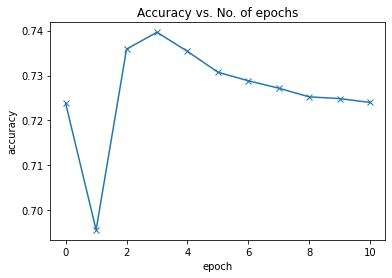

In [30]:
history = [resultg] + h1 + h2 
accuracies = [result['test_acc'] for result in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

In [31]:
optimizer=torch.optim.Adam(model.parameters(),lr=0.001)
loss_function= nn.CrossEntropyLoss()

In [32]:
from tqdm.notebook import tqdm
import torch.nn.functional as F#

In [33]:
optimizer=torch.optim.Adam(model.parameters(),lr=0.001)
loss_function= nn.CrossEntropyLoss()

In [34]:
test_x=feed_device(test_x,device)
test_y=feed_device(test_y,device)

In [35]:
out=model(test_x)
_, preds = torch.max(out, dim=1)
print("accuracy:",torch.tensor(torch.sum(preds == test_y).item() / len(preds)))
#cpu 15epoch 

accuracy: tensor(0.5717)


In [36]:
out=model(test_x)
_, preds = torch.max(out, dim=1)
print("accuracy:",torch.tensor(torch.sum(preds == test_y).item() / len(preds)))
#cpu 15epoch 

accuracy: tensor(0.5717)


In [37]:
out=model(test_x)
_, preds = torch.max(out, dim=1)
print("accuracy:",torch.tensor(torch.sum(preds == test_y).item() / len(preds)))
#cpu 15epoch 

accuracy: tensor(0.5717)


In [38]:
k=0
for i in range(0,len(test_y)):
    if test_y[i]==preds[i]:
        k=k+1
print(k)
     

11519


In [39]:
out=model(test_x)
_, preds = torch.max(out, dim=1)
print("accuracy:",torch.tensor(torch.sum(preds == test_y).item() / len(preds)))
#cpu 15epoch 

accuracy: tensor(0.5717)
